# Object-based landuse classification

## Introduction

[link](https://towardsdatascience.com/object-based-land-cover-classification-with-python-cbe54e9c9e24)

An in-depth explanation of GEOBIA can be found [here](https://www.mdpi.com/2072-4292/12/12/2012#). A practical example can be found [here](https://www.mdpi.com/2072-4292/6/7/6111).

Aerial images cover the entire globe at various spatial and temporal resolutions. Timely extraction of information from aerial images requires automated analysis to train computers to recognize what the human eye immediately identifies. Object-based image analysis (OBIA) improves processing efficiency by implementing image segmentation algorithms to combine groups of pixels into objects (segments) reducing the amount of information in and image. This article describes how to use open source Python packages to perform image segmentation and land cover classification of an aerial image. Specifically, I will demonstrate the process of geographic object-based image analysis (GeOBIA)to perform supervised land cover classification in 5 steps:

1. Image segmentation
2. Quantify segment spectral properties
3. Groundtruth data
4. Land cover classification
5. Accuracy assessment

### Importing the Python modules

The first step is to import the modules we are going to use in this exercise:

In [1]:
# Imports from scikit-image, scipy and sklearn
import scipy
from skimage import exposure
from skimage.segmentation import slic
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

# Imports gdal and ogr
from osgeo import gdal
from osgeo import gdalconst
from osgeo import ogr
from osgeo import osr
from osgeo import gdalnumeric
from osgeo import gdal_array

# Import rasterio
import rasterio
from rasterio import features
from rasterio.mask import mask
from rasterio.plot import show
from rasterio.features import shapes

# Import numpy, pandas and geopandas
import os
import random
import numpy as np
import pandas as pd
import geopandas as gpd

# Imports matplotlib and seaborn for visualisation
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

## 1. Image segmentation

Image segmentation is a method in which a digital image is broken down into various subgroups called Image segments which helps in reducing the complexity of the image to make further processing or analysis of the image simpler. Segmentation in easy words is assigning labels to pixels. All picture elements or pixels belonging to the same category have a common label assigned to them. 

Segmentation effectively reduces the number of elements in an image that need to be classified. This may reduce an image with 1 million pixels down to 50,000 segments, which is much more manageable.

[Here](https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_segmentations.html#sphx-glr-auto-examples-segmentation-plot-segmentations-py) you can read more about image segmentation. 

### Setting the imput parameters

After importing the modules, we have to define the locations and the names of the folders and files we are going to use and going to create. 

We are going to use a satellite image from Waalwijk. Run the following codeblock to define the input files:

In [2]:
# Folder with data files
data_folder = 'data_files/Waalwijk/' 
sentinel_folder = data_folder + 'sentinel-2/'

# Name shapefile with sample areas 
sample_areas_vector_file = data_folder + '/samples_areas.shp'

# Name of geojson with landuse classes to be used as groundtruth
sample_points_vector_file = data_folder + '/sample_points.geojson'

# Name of column with landuse class
landuse_column = 'landuse'

# Name of column with ID of landuse class
landuse_id_column = 'landuse_id'

# File with relation between landuse class and id
landuse_class_lookup_file = data_folder + '/landuse_id_lookup.csv'

# Name of geolsjon file for training and testing
train_data_vector_file = data_folder + '/train_data.geojson'
test_data_vector_file = data_folder + '/test_data.geojson'

# Name rasterfile with segments
segments_raster_file = data_folder + '/segments.tif'

# Name of new GeoTIFF file with all bands
sentinel_bands_raster_file = data_folder + 'sentinel_bands.tif'

# Name of new GeoTIFF file with groud truth sample areas
sample_areas_raster_file = os.path.splitext(sample_areas_vector_file)[0] + '.tif'

# Name of new Geotiff file with classified landuse classes
classified_landuse_raster_file = data_folder + 'classified_geobia.tif'
classified_landuse_vector_file = data_folder + 'classified_geobia.shp'

### Preparing the satellite images

Now we need to collect all the Sentinel-2 bands because they come as individual images one per band. We merge them into one GeoTIFF image with multiple bands and then we plot the individual bands and the a false color composite for a visual inspection.

In [3]:
# Find every file in the sentinal directory
sentinal_band_paths_array = [os.path.join(sentinel_folder, f) for f in os.listdir(sentinel_folder) if os.path.isfile(os.path.join(sentinel_folder, f))]
sentinal_band_paths_array.sort()

# Read metadata of first file and assume all other bands are the same
with rasterio.open(sentinal_band_paths_array[0]) as sentinal_band_path_handle:
    meta = sentinal_band_path_handle.meta

# Update metadata to reflect the number of layers
meta.update(count = len(sentinal_band_paths_array))

# Read each layer and write it to stack
with rasterio.open(sentinel_bands_raster_file, 'w', **meta) as sentinel_bands_handle:
    for id, layer in enumerate(sentinal_band_paths_array, start=1):
        with rasterio.open(layer) as layer_handle:
            sentinel_bands_handle.write_band(id, layer_handle.read(1))

# Close files
sentinal_band_path_handle = None
sentinel_bands_handle = None

The code below demonstrates segmentation with the SLIC (Simple linear iterative clustering). First, each of the 4 bands (red, blue, green, near-infrared) from the image is read as a `numpy` array with `gdal`. Band data are re-scaled to intensity values (ranging from 0–1). Then segments are created. Segments are saved to a new raster with `gdal`.

In [4]:
# Open rastefile with bands
driverTiff = gdal.GetDriverByName('GTiff')
sentinel_bands_handle = gdal.Open(sentinel_bands_raster_file)
nbands = sentinel_bands_handle.RasterCount
band_data = []

# Build stack with all band arrays and rescale between 0 and 1
for i in range(1, nbands+1):
    band = sentinel_bands_handle.GetRasterBand(i).ReadAsArray()
    band_data.append(band)
band_data = np.dstack(band_data)
img = exposure.rescale_intensity(band_data)

# Estimate the number of segments
number_of_pixels = sentinel_bands_handle.RasterXSize * sentinel_bands_handle.RasterYSize
print('Image has ' + str(number_of_pixels) + ' pixels')
max_number_of_segments = number_of_pixels/100
print('Reasonable number of segments for SLIC is estimated at ' + str(int(max_number_of_segments)))

# Segmentation, different options with quickshift and slic (only use one of the next two lines)
segments = slic(img, n_segments=max_number_of_segments, compactness=0.1)
print('Segmentation complete')
 
# Save segments to raster
segments_fn = segments_raster_file
segments_ds = driverTiff.Create(segments_fn, sentinel_bands_handle.RasterXSize, sentinel_bands_handle.RasterYSize,
                                1, gdal.GDT_Float32)
segments_ds.SetGeoTransform(sentinel_bands_handle.GetGeoTransform())
segments_ds.SetProjection(sentinel_bands_handle.GetProjectionRef())
segments_ds.GetRasterBand(1).WriteArray(segments)
segments_ds = None
segments_fn = None

# Print name of segments file
print('Generated segments stored as ' + str(segments_raster_file))

# TO DO: Vectorize segments.tif 
# TO DO: Plot vectorized segments.shp on top of satellite image

Image has 1059682 pixels
Reasonable number of segments for SLIC is estimated at 10596
Segmentation complete
Generated segments stored as data_files/Waalwijk//segments.tif


The segments from the SLIC algorithm follow the boundaries of image features. Be sure to assess your segments before continuing with classification.

### Explanation of SLIC

SLIC (Simple Linear Iterative Clustering) is an algorithm for Superpixel generation. A superpixel can be defined as a group of pixels that share common characteristics (like pixel intensity ). They are often used in image classification because:

- They carry more information than pixels.
- They have a perceptual meaning since pixels belonging to a given superpixel share similar visual properties.
- They provide a compact representation of images that can be useful for computationally demanding problems like landuse classification.

The SLIC algorithm generates superpixels by clustering pixels based on their color similarity and proximity in the image plane. [Here](https://www.mdpi.com/2072-4292/9/3/243) you can find an explanation of the the SLIC algorithm.

https://www.mdpi.com/2072-4292/9/3/243





## 2. Quantify segment spectral properties

Once the image is segmented the spectral properties of each segment must be quantitatively described. Given a number of pixels, the function below calculates descriptive statistics (e.g. mean, max, min, variance) for each band. These are the values that will be used by the random forests algorithm to classify the segments into landuse types.



In [6]:
# Function to calculate stats for each segment
def segment_features(segment_pixels):
    features = []
    npixels, nbands = segment_pixels.shape
    for b in range(nbands):
        stats = scipy.stats.describe(segment_pixels[:, b])
        band_stats = list(stats.minmax) + list(stats)[2:]
        if npixels == 1:
            # In this case the variance = nan, change it 0.0
            band_stats[3] = 0.0
        features += band_stats
    return features

Now, we loop through each segment, send the pixels from each segment to the `segment_features` function and save the results in a list. See [here](https://towardsdatascience.com/skewness-kurtosis-simplified-1338e094fc85) for an explanation of skewness and kurtosis.

In [7]:
# Get the unique ID's for the segments
segment_ids = np.unique(segments)

# Init the lists 
objects = []
object_ids = []

# For each segment
for id in segment_ids:

    # Select pixels with same ID
    segment_pixels = img[segments == id]

    # Call function to calculate stats for each segment and store stats and ID's in lists
    object_features = segment_features(segment_pixels)
    objects.append(object_features)
    object_ids.append(id)

# Print stats for last segment
print('Example of the statistics of the first band of the last segment')
print('Minimum = ' + str(object_features[0]))
print('Maximum = ' + str(object_features[1]))
print('Mean  = ' + str(object_features[2]))
print('Variance  = ' + str(object_features[3]))
print('Skewness  = ' + str(object_features[4]))
print('Skewness  = ' + str(object_features[5]))

Example of the statistics of the first band of the last segment
Minimum = 636
Maximum = 944
Mean  = 790.5949367088608
Variance  = 4144.474845829276
Skewness  = -0.03892043941901203
Skewness  = -0.058486969391952304


## 3. Groundtruth data

This is a supervised classification workflow, so you’ll need to have some groundtruth data describing the landuse types represented in your classification. 

The landuse truth data need to be split into training and test data sets. The training data set will train the random forests classification algorithm. We will compare the classification results to the test data set to assess classification accuracy.

The landuse data is available as a geojson. The code below uses `geopandas` to read the groundtruth data as a geodataframe. Randomly, 70% of the truth observations are assigned to a training data set and the remaining 30% to a testing data set. The training and test data sets are each saved to a new geojson. During this process I also used a lookup table that I created to give names to each land cover class (lines 8–11). This is not necessary, but makes it easier to see what each class represents.

In [8]:
# Read shapefile to geopandas geodataframe
gdf = gpd.read_file(sample_points_vector_file)

# Get names of landuse classes/labels
class_names = gdf[landuse_column].unique()
print(class_names)

# Create a unique id (integer) for each landuse class/label
class_ids = np.arange(class_names.size) + 1

# Create a pandas data frame of the labels and ids and save to csv
df = pd.DataFrame({landuse_column: class_names, landuse_id_column: class_ids})
df.to_csv(landuse_class_lookup_file)

# Add a new column to geodatafame with the id for each class/label
gdf[landuse_id_column] = gdf[landuse_column].map(dict(zip(class_names, class_ids)))
 
# split the truth data into training and test data sets and save each to a new shapefile
gdf_train = gdf.sample(frac=0.7)  # 70% of observations assigned to training data (30% to test data)
gdf_test = gdf.drop(gdf_train.index)

# Save training and test data to shapefiles
gdf_train.to_file(train_data_vector_file)
gdf_test.to_file(test_data_vector_file)

['shrubs' 'water' 'cropland' 'buildings' 'sand' 'forest' 'grass']


c:\Software\Python311\Lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
c:\Software\Python311\Lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Now, convert the training data to raster format so each observation point can be associated with an image segment.

In [9]:
# Open the trainings dataset
train_ds = ogr.Open(train_data_vector_file)
lyr = train_ds.GetLayer()

# Create a new raster layer in memory
driver = gdal.GetDriverByName('MEM')
target_ds = driver.Create('', sentinel_bands_handle.RasterXSize, sentinel_bands_handle.RasterYSize, 1, gdal.GDT_UInt16)
target_ds.SetGeoTransform(sentinel_bands_handle.GetGeoTransform())
target_ds.SetProjection(sentinel_bands_handle.GetProjection())

# Rasterize the training points
options = ['ATTRIBUTE=' + str(landuse_id_column)]
gdal.RasterizeLayer(target_ds, [1], lyr, options=options)



0

Associate each training observation with the corresponding image segment. Lines 13–19 ensure that each training observation is associated with only one segment. Because segments include multiple pixels, it is possible that segments represent multiple land cover types. This is why it is important to properly tune your segmentation algorithm.



In [10]:
# Read groundtruth raster into array
ground_truth = target_ds.GetRasterBand(1).ReadAsArray()

# Get unique values of landuse classes from raster (0 is the background, or no data, value so it is not included) 
landuse_classes = np.unique(ground_truth)[1:]

# For each landuse class record the associated segment IDs from the segments array and store in dictionary
segments_per_class = {}
for landuse_class in landuse_classes:
    segments_of_class = segments[ground_truth == landuse_class]
    print('The following segments overlap with landuse class ' + str(landuse_class) + ': ' + str(segments_of_class))
    segments_per_class[landuse_class] = set(segments_of_class)
 
# Make sure no segment ID voerlaps with only one class
intersection = set()
accum = set()
for class_segments in segments_per_class.values():
    intersection |= accum.intersection(class_segments)
    accum |= class_segments
assert len(intersection) == 0, "Segment(s) represent multiple classes"

The following segments overlap with landuse class 1: [7785 8044 8317 8882]
The following segments overlap with landuse class 2: [3560 4406 4676 5010 7265 7467 8049]
The following segments overlap with landuse class 3: [2753 3070 3007 4244 4319 4988 5266 5983 6257 7859]
The following segments overlap with landuse class 4: [ 991 1555 1729 1924 1962 2919 3286 6000]
The following segments overlap with landuse class 5: [6663 7120 7631 7971 8069 8323 9107 9273]
The following segments overlap with landuse class 6: [5185 5252 5818 6567 7180 7305 7420 8105 8921]
The following segments overlap with landuse class 7: [3213 3483 3761 3882 3988 3984 4965 6348 7463 7856]


## 4. Landuse Classification

This is the meat of the analysis. The classification algorithm. First, identify and label the training objects (lines 1–20). This process involves associating a label (land cover type) with the statistics describing each spectral band within the image segment.

Now, everything is now set up to train a classifier and use it to predict across all segments in the image. Here I’m using random forests, a popular classification algorithm. The code to train (fit) the algorithm and make predictions is quite simple (lines 22–24). Simply pass the training objects (containing the spectral properties) and the associated land cover label to the classifier. Once the classifier is trained (fitted) predictions can be made for non-training segments based on their spectral properties. After the predictions are made, save them to raster for display in a GIS (lines 26–43).

In [11]:
train_img = np.copy(segments)
threshold = train_img.max() + 1  # Make the threshold value greater than any landuse class value

# All pixels in training segments assigned value greater than threshold
for landuse_class in landuse_classes:
    class_label = threshold + landuse_class
    for segment_id in segments_per_class[landuse_class]:
        train_img[train_img == segment_id] = class_label
 
# Training segments receive landuse class value, all other segments 0
train_img[train_img <= threshold] = 0
train_img[train_img > threshold] -= threshold

# Create objects and labels for training data
training_objects = []
training_labels = []
for landuse_class in landuse_classes:
    class_train_object = [v for i, v in enumerate(objects) if segment_ids[i] in segments_per_class[landuse_class]]
    training_labels += [landuse_class] * len(class_train_object)
    training_objects += class_train_object
 
classifier = RandomForestClassifier(n_jobs=-1)  # Setup random forest classifier
classifier.fit(training_objects, training_labels)  # Fit rf classifier
predicted = classifier.predict(objects)  # Predict with rf classifier

# Create numpy array from rf classification and save to raster
clf = np.copy(segments)
for segment_id, klass in zip(segment_ids, predicted):
    clf[clf == segment_id] = klass

# This section masks no data values 
mask = np.sum(img, axis=2)  
mask[mask > 0.0] = 1.0
mask[mask == 0.0] = -1.0
clf = np.multiply(clf, mask)
clf[clf < 0] = -9999.0

# Store the result as a rasterfile 
clfds = driverTiff.Create(classified_landuse_raster_file, sentinel_bands_handle.RasterXSize, sentinel_bands_handle.RasterYSize,
                          1, gdal.GDT_Float32)  
clfds.SetGeoTransform(sentinel_bands_handle.GetGeoTransform())
clfds.SetProjection(sentinel_bands_handle.GetProjection())
clfds.GetRasterBand(1).SetNoDataValue(-9999.0)
clfds.GetRasterBand(1).WriteArray(clf)
clfds = None

# Print name of file
print('Classification can be found in rasterfile ' + str(classified_landuse_raster_file))

Classification can be found in rasterfile data_files/Waalwijk/classified_geobia.tif


## 5. Accuracy Assessment with a Confusion Matrix

Accuracy assessment is a crucial aspect of any classification. If your classification doesn’t represent what it’s supposed to, it’s not worth much. 

Load the test data set created earlier and convert it to raster format so it is compatible with the generated predictions. Then simply query the predicted values from the locations where test data exist. Finally, generate the confusion matrix from the corresponding values.

Note: We classified segments, but this accuracy assessment compares pixels. We’re comparing all the pixels in each test segment to all the pixels in the corresponding predicted segment. This could lead to some bias if certain land cover classes are more frequently found in smaller (or larger) segments than others. Again, if you have done due diligence with image segmentation, this shouldn’t be a problem.

Accuracy: 0.6666666666666666


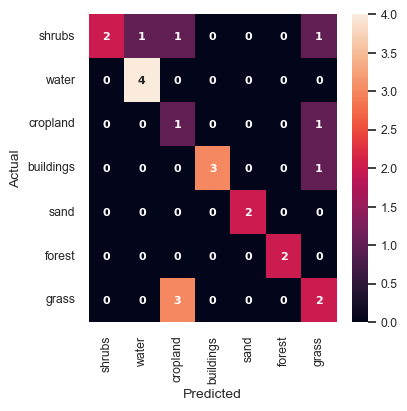

In [13]:
# Read original image to get info for raster dimensions
naip_fn = classified_landuse_raster_file
driverTiff = gdal.GetDriverByName('GTiff')
naip_ds = gdal.Open(naip_fn)
 
# Rasterize test data for pixel-to-pixel comparison
test_fn = test_data_vector_file
test_ds = ogr.Open(test_fn)
lyr = test_ds.GetLayer()
driver = gdal.GetDriverByName('MEM')
target_ds = driver.Create('', sentinel_bands_handle.RasterXSize, sentinel_bands_handle.RasterYSize, 1, gdal.GDT_UInt16)
target_ds.SetGeoTransform(sentinel_bands_handle.GetGeoTransform())
target_ds.SetProjection(sentinel_bands_handle.GetProjection())
options = ['ATTRIBUTE=' + str(landuse_id_column)]
gdal.RasterizeLayer(target_ds, [1], lyr, options=options)

# Get testdata as array 
truth = target_ds.GetRasterBand(1).ReadAsArray()  

# Open rasterfile with predictions 
pred_ds = gdal.Open(classified_landuse_raster_file)  
pred = pred_ds.GetRasterBand(1).ReadAsArray() 
idx = np.nonzero(truth) 

# Create a confusion matrix at the truth/test locations
cm = metrics.confusion_matrix(truth[idx], pred[idx])  
df_conf_matrix = pd.DataFrame(cm,columns=class_names,index=class_names)

# Plot confusion matrix heatmap
plt.figure(figsize=(4, 4))
sns.set(font_scale=0.8)
sns.heatmap(df_conf_matrix,
            #cmap='coolwarm',
            annot=True,
            fmt='.5g',
            annot_kws={
                'fontsize': 8,
                'fontweight': 'bold',
                'fontfamily': 'DejaVu Sans'
            })
plt.xlabel('Predicted',fontsize=10)
plt.ylabel('Actual',fontsize=10)
 
# Model Accuracy, how often is the classifier correct?
print("Accuracy: " + str(metrics.accuracy_score(truth[idx], pred[idx])))
